In [87]:
import utils

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

import numpy as np
import os

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import logging

In [2]:
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 1.15.5
	• tf.keras version: 2.2.4-tf
	• Running on GPU


In [3]:
basedir = os.path.join("C:\\Users\\manos\\git\\metacovid-siamese-neural-network", "dataset", "siamese") 

train_image_list, train_y_list = utils.load_images(basedir, 'train', (100,100))
print("The train set contains",len(train_image_list)) 

valid_image_list, valid_y_list = utils.load_images(basedir, 'validation', (100,100))   
print("The valid set contains", len(valid_image_list))  

test_image_list, test_y_list = utils.load_images(basedir, 'test', (100,100))   
print("The test set contains", len(test_image_list)) 

Found 30 images belonging to 3 classes.
The train set contains 30
Found 30 images belonging to 3 classes.
The valid set contains 30
Found 648 images belonging to 3 classes.
The test set contains 648


In [4]:
# make train pairs
pairs_train, labels_train = utils.make_pairs(train_image_list, train_y_list)

# make validation pairs
pairs_val, labels_val = utils.make_pairs(valid_image_list, valid_y_list)

# make test pairs
pairs_test, labels_test = utils.make_pairs(test_image_list, test_y_list)

x_train_1 = pairs_train[:, 0]  
x_train_2 = pairs_train[:, 1]
print("number of pairs for training", np.shape(x_train_1)[0]) 

x_val_1 = pairs_val[:, 0] 
x_val_2 = pairs_val[:, 1]
print("number of pairs for validation", np.shape(x_val_1)[0]) 

x_test_1 = pairs_test[:, 0] 
x_test_2 = pairs_test[:, 1]
print("number of pairs for test", np.shape(x_test_1)[0]) 

number of pairs for training 60
number of pairs for validation 60
number of pairs for test 1296


In [5]:
tf.compat.v1.reset_default_graph()

SIAMESE_MODEL_FNAME = 'siamese_network.h5'
EMBEDDING_MODEL_FNAME = 'embedding_network.h5'

input_1 = Input((100,100,3))
input_2 = Input((100,100,3))

embedding_network = tf.keras.models.load_model(EMBEDDING_MODEL_FNAME)
embedding_network.trainable = False

model = tf.keras.Sequential() 
for layer in embedding_network.layers:  
    model.add(layer) 

model.add(Flatten(name='flat'))
model.add(Dense(5120, name='den', activation='sigmoid', kernel_regularizer='l2')) 
 
output_1 = model(input_1) 
output_2 = model(input_2) 
 
merge_layer = Lambda(utils.manhattan_distance)([output_1, output_2]) 
output_layer = Dense(1, activation="sigmoid")(merge_layer) 
siamese = Model(inputs=[input_1, input_2], outputs=output_layer) 
siamese.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 5120)         14748995    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[1][0]             

In [6]:
""" callbacks """

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=0.0001)

checkpointer = ModelCheckpoint(filepath='siamese_network.h5', verbose=1, 
                                save_best_only=True)

In [7]:
""" train the model """

optimizer = Adam(learning_rate=0.0001)
siamese.compile(loss=utils.loss(1), optimizer=optimizer, metrics=["accuracy"])
# siamese.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

siamese.summary()
history = siamese.fit([x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=1,
    epochs=175,   # 175 for contrastive 100 for cross ent
    callbacks = [checkpointer, early_stopping, reduce_lr]
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 5120)         14748995    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[1][0]             

Epoch 23/175
59/60 [============================>.] - ETA: 0s - loss: 0.1216 - acc: 0.8983
Epoch 00023: val_loss did not improve from 0.15852
60/60 [==============================] - 7s 120ms/sample - loss: 0.1235 - acc: 0.9000 - val_loss: 0.1599 - val_acc: 0.7500
Epoch 24/175
59/60 [============================>.] - ETA: 0s - loss: 0.1253 - acc: 0.8983
Epoch 00024: val_loss did not improve from 0.15852
60/60 [==============================] - 7s 117ms/sample - loss: 0.1233 - acc: 0.9000 - val_loss: 0.1613 - val_acc: 0.7500
Epoch 25/175
59/60 [============================>.] - ETA: 0s - loss: 0.1246 - acc: 0.8983
Epoch 00025: val_loss did not improve from 0.15852
60/60 [==============================] - 7s 120ms/sample - loss: 0.1226 - acc: 0.9000 - val_loss: 0.1590 - val_acc: 0.7667
Epoch 26/175
59/60 [============================>.] - ETA: 0s - loss: 0.1240 - acc: 0.8983
Epoch 00026: val_loss improved from 0.15852 to 0.15775, saving model to siamese_network.h5
60/60 [================

Epoch 52/175
59/60 [============================>.] - ETA: 0s - loss: 0.1083 - acc: 0.9831
Epoch 00052: val_loss did not improve from 0.14692
60/60 [==============================] - 7s 116ms/sample - loss: 0.1099 - acc: 0.9833 - val_loss: 0.1472 - val_acc: 0.8500
Epoch 53/175
59/60 [============================>.] - ETA: 0s - loss: 0.1111 - acc: 0.9831
Epoch 00053: val_loss improved from 0.14692 to 0.14591, saving model to siamese_network.h5
60/60 [==============================] - 7s 119ms/sample - loss: 0.1093 - acc: 0.9833 - val_loss: 0.1459 - val_acc: 0.8667
Epoch 54/175
59/60 [============================>.] - ETA: 0s - loss: 0.1106 - acc: 0.9831
Epoch 00054: val_loss improved from 0.14591 to 0.14532, saving model to siamese_network.h5
60/60 [==============================] - 7s 118ms/sample - loss: 0.1089 - acc: 0.9833 - val_loss: 0.1453 - val_acc: 0.8667
Epoch 55/175
59/60 [============================>.] - ETA: 0s - loss: 0.1065 - acc: 0.9831
Epoch 00055: val_loss did not impr

Epoch 81/175
59/60 [============================>.] - ETA: 0s - loss: 0.0954 - acc: 0.9831
Epoch 00081: val_loss did not improve from 0.13421
60/60 [==============================] - 7s 117ms/sample - loss: 0.0972 - acc: 0.9833 - val_loss: 0.1348 - val_acc: 0.8667
Epoch 82/175
59/60 [============================>.] - ETA: 0s - loss: 0.0985 - acc: 1.0000
Epoch 00082: val_loss did not improve from 0.13421
60/60 [==============================] - 7s 115ms/sample - loss: 0.0970 - acc: 1.0000 - val_loss: 0.1368 - val_acc: 0.8667
Epoch 83/175
59/60 [============================>.] - ETA: 0s - loss: 0.0945 - acc: 0.9831- ETA: 0s - loss: 0.1014 - acc: 
Epoch 00083: val_loss improved from 0.13421 to 0.13393, saving model to siamese_network.h5
60/60 [==============================] - 7s 122ms/sample - loss: 0.0964 - acc: 0.9833 - val_loss: 0.1339 - val_acc: 0.8667
Epoch 84/175
59/60 [============================>.] - ETA: 0s - loss: 0.0977 - acc: 0.9831
Epoch 00084: val_loss did not improve from

59/60 [============================>.] - ETA: 0s - loss: 0.0875 - acc: 1.0000
Epoch 00109: val_loss did not improve from 0.12403
60/60 [==============================] - 7s 113ms/sample - loss: 0.0861 - acc: 1.0000 - val_loss: 0.1251 - val_acc: 0.8667
Epoch 110/175
59/60 [============================>.] - ETA: 0s - loss: 0.0871 - acc: 1.0000
Epoch 00110: val_loss did not improve from 0.12403
60/60 [==============================] - 7s 118ms/sample - loss: 0.0858 - acc: 1.0000 - val_loss: 0.1244 - val_acc: 0.8667
Epoch 111/175
59/60 [============================>.] - ETA: 0s - loss: 0.0841 - acc: 1.0000
Epoch 00111: val_loss improved from 0.12403 to 0.12363, saving model to siamese_network.h5
60/60 [==============================] - 7s 117ms/sample - loss: 0.0853 - acc: 1.0000 - val_loss: 0.1236 - val_acc: 0.8667
Epoch 112/175
59/60 [============================>.] - ETA: 0s - loss: 0.0839 - acc: 1.0000
Epoch 00112: val_loss did not improve from 0.12363
60/60 [==========================

Epoch 138/175
59/60 [============================>.] - ETA: 0s - loss: 0.0822 - acc: 1.0000
Epoch 00138: val_loss improved from 0.11979 to 0.11963, saving model to siamese_network.h5
60/60 [==============================] - 7s 123ms/sample - loss: 0.0809 - acc: 1.0000 - val_loss: 0.1196 - val_acc: 0.8667
Epoch 139/175
59/60 [============================>.] - ETA: 0s - loss: 0.0822 - acc: 1.0000- ETA: 0s - loss: 0.0864 - 
Epoch 00139: val_loss improved from 0.11963 to 0.11960, saving model to siamese_network.h5
60/60 [==============================] - 7s 123ms/sample - loss: 0.0809 - acc: 1.0000 - val_loss: 0.1196 - val_acc: 0.8667
Epoch 140/175
59/60 [============================>.] - ETA: 0s - loss: 0.0795 - acc: 1.0000
Epoch 00140: val_loss did not improve from 0.11960
60/60 [==============================] - 7s 113ms/sample - loss: 0.0808 - acc: 1.0000 - val_loss: 0.1198 - val_acc: 0.8667
Epoch 141/175
59/60 [============================>.] - ETA: 0s - loss: 0.0797 - acc: 1.0000- ET

59/60 [============================>.] - ETA: 0s - loss: 0.0812 - acc: 1.0000
Epoch 00166: val_loss did not improve from 0.11878
60/60 [==============================] - 7s 117ms/sample - loss: 0.0799 - acc: 1.0000 - val_loss: 0.1188 - val_acc: 0.8667
Epoch 167/175
59/60 [============================>.] - ETA: 0s - loss: 0.0782 - acc: 1.0000
Epoch 00167: val_loss improved from 0.11878 to 0.11867, saving model to siamese_network.h5
60/60 [==============================] - 7s 116ms/sample - loss: 0.0798 - acc: 1.0000 - val_loss: 0.1187 - val_acc: 0.8667
Epoch 168/175
59/60 [============================>.] - ETA: 0s - loss: 0.0811 - acc: 1.0000
Epoch 00168: val_loss did not improve from 0.11867
60/60 [==============================] - 7s 114ms/sample - loss: 0.0798 - acc: 1.0000 - val_loss: 0.1187 - val_acc: 0.8667
Epoch 169/175
59/60 [============================>.] - ETA: 0s - loss: 0.0811 - acc: 1.0000
Epoch 00169: val_loss did not improve from 0.11867
60/60 [==========================

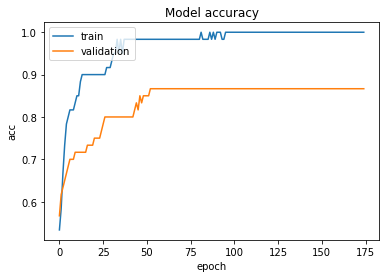

In [8]:
# Plot the accuracy
utils.plt_metric(history=history.history, metric="acc", title="Model accuracy")

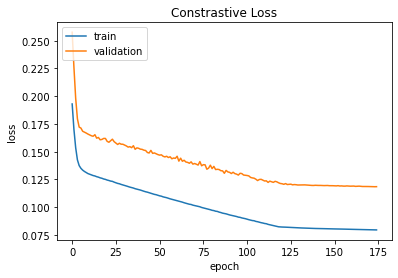

In [9]:
# Plot the constrastive loss
utils.plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

In [10]:
""" Test the model """
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

1296/1296 [==============================] - 52s 40ms/sample - loss: 0.0971 - acc: 0.9483
test loss, test acc: [0.09711058033101352, 0.94830245]


In [73]:
Y_pred = siamese.predict([x_test_1, x_test_2]).squeeze()
Y_pred

array([[0.40711525],
       [0.1815041 ],
       [0.62134373],
       ...,
       [0.05995859],
       [0.5771121 ],
       [0.04537573]], dtype=float32)

In [77]:
Y_pred.mean()

0.32110322

In [79]:
# y_pred = np.argmax(Y_pred, axis=1)
y_pred = Y_pred > Y_pred.mean()
y_pred

array([[ True],
       [False],
       [ True],
       ...,
       [False],
       [ True],
       [False]])

In [80]:
y_test = labels_test
y_test

array([1., 0., 1., ..., 0., 1., 0.], dtype=float32)

In [81]:
print("\nEvaluate on test data")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("ROC AUC:", roc_auc_score(y_test, y_pred, average='weighted'))
print("F1:", f1_score(y_test, y_pred, average='weighted'))


Evaluate on test data
Accuracy: 0.9768518518518519
Precision: 0.9773065334299552
Recall: 0.9768518518518519
ROC AUC: 0.9768518518518517
F1: 0.9768463378147898


In [91]:
cm = confusion_matrix(y_test, y_pred)    
# cm_display = ConfusionMatrixDisplay(cm, labels_test).plot()

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn+fp)
print("Specificity:", specificity)

Specificity: 0.9922839506172839


In [92]:
tf.keras.backend.clear_session()